# Data processing

**Step 1:** Importing Libraries and Loading Data Set

In [79]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer, PowerTransformer, PolynomialFeatures

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression,ElasticNetCV, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor

train_ds_original = pd.read_csv('/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/train.csv')
train_ds = pd.read_csv('/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/train.csv')
test_ds = pd.read_csv('/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/test.csv')

# want to see the data set shape
print("Given Train Data set Shape: ", train_ds.shape)

# Get Dataset info
train_ds.info()

# Summary Statisitcs
train_ds.describe()

Given Train Data set Shape:  (5000, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hospital_Id           5000 non-null   object 
 1   Supplier_Name         5000 non-null   object 
 2   Supplier_Reliability  4413 non-null   float64
 3   Equipment_Height      4717 non-null   float64
 4   Equipment_Width       4557 non-null   float64
 5   Equipment_Weight      4540 non-null   float64
 6   Equipment_Type        4401 non-null   object 
 7   Equipment_Value       5000 non-null   float64
 8   Base_Transport_Fee    5000 non-null   float64
 9   CrossBorder_Shipping  5000 non-null   object 
 10  Urgent_Shipping       5000 non-null   object 
 11  Installation_Service  5000 non-null   object 
 12  Transport_Method      3929 non-null   object 
 13  Fragile_Equipment     5000 non-null   object 
 14  Hospital_Info         5000 non-n

,Supplier_Reliability,Equipment_Height,Equipment_Width,Equipment_Weight,Equipment_Value,Base_Transport_Fee,Transport_Cost
count,4413.000000,4717.000000,4557.000000,4.540000e+03,5000.000000,5000.000000,5.000000e+03
mean,0.460925,21.759593,9.585034,4.097584e+05,1190.293363,37.374362,1.789806e+04
std,0.265964,11.944434,5.407542,2.808640e+06,8724.804213,26.907914,2.554261e+05
min,0.000000,3.000000,2.000000,3.000000e+00,3.000000,10.000000,-5.881832e+05
25%,0.230000,12.000000,6.000000,5.070000e+02,5.260000,16.630000,1.884150e+02
50%,0.450000,20.000000,8.000000,3.137500e+03,7.935000,23.410000,3.776050e+02
75%,0.670000,30.000000,12.000000,3.694150e+04,87.047500,57.805000,1.182702e+03
max,1.000000,73.000000,50.000000,1.179279e+08,382385.670000,99.980000,1.114343e+07


**Step 2:** Feature Grouping
> dealing with the same kind of features is easy

In [80]:
# columns having unique values.
drop_cols = ["Hospital_Id", "Supplier_Name", "Hospital_Location"]

# Our target column
target = "Transport_Cost"

# our features, numerical, categorical and their respective missing groups and Date feature grouping
numeric_features_median = ['Equipment_Height', 'Equipment_Width', 'Equipment_Weight', 'Supplier_Reliability']
categorical_features_unknown = ['Equipment_Type', 'Transport_Method', 'Rural_Hospital']
no_missing_features_numerical = ['Equipment_Value', 'Base_Transport_Fee']
no_missing_features_categorical = ['Fragile_Equipment', 'Hospital_Info', 'CrossBorder_Shipping', 'Urgent_Shipping', 'Installation_Service']
date_features = ['Order_Placed_Date', 'Delivery_Date']

# droping unique values columns in both data sets, because they cause our model to Overfit.
train_ds = train_ds.drop(columns=drop_cols)
test_ds = test_ds.drop(columns=drop_cols)

**Step 3:** Dealing with Date Function and applying feature engineering to date group
> 1. Since date function is cyclic feature not a normal numeric feature so 
> we need to deal with it appropriately.
> 2. Also doing feature engineering for data features, => increasing data features

In [81]:
def compute_date_features(df_dates):
    df = df_dates.copy()
    df = df.apply(pd.to_datetime, format="%m/%d/%y", errors="coerce")
    order = df.iloc[:, 0]
    delivery = df.iloc[:, 1]
    delivery_days = (delivery - order).dt.days
    order_dow = order.dt.dayofweek.fillna(-1).astype(float)
    order_month = order.dt.month.fillna(0).astype(float)
    delivery_dow = delivery.dt.dayofweek.fillna(-1).astype(float)
    delivery_month = delivery.dt.month.fillna(0).astype(float)
    order_is_weekend = order_dow.isin([5, 6]).astype(float)
    delivery_is_weekend = delivery_dow.isin([5, 6]).astype(float)

    def cyc(x, period):
        xr = x.replace(-1, 0)
        rad = 2 * np.pi * xr / period
        return np.sin(rad), np.cos(rad)

    order_dow_sin, order_dow_cos = cyc(order_dow, 7)
    order_month_sin, order_month_cos = cyc(order_month, 12)

    features = pd.DataFrame({
        "delivery_days": delivery_days,
        "order_dow_sin": order_dow_sin,
        "order_dow_cos": order_dow_cos,
        "order_month_sin": order_month_sin,
        "order_month_cos": order_month_cos,
        "order_is_weekend": order_is_weekend,
        "delivery_is_weekend": delivery_is_weekend,
    })
    features.index = df_dates.index
    return features

In [82]:
# checking the engineered features are present or not. Pandas has converted data set or not.
train_ds.sample(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Supplier_Reliability,Equipment_Height,Equipment_Width,Equipment_Weight,Equipment_Type,Equipment_Value,Base_Transport_Fee,CrossBorder_Shipping,Urgent_Shipping,Installation_Service,Transport_Method,Fragile_Equipment,Hospital_Info,Rural_Hospital,Order_Placed_Date,Delivery_Date,Transport_Cost
3230,0.57,41.0,17.0,3257.0,Aluminium,24.82,20.96,Yes,No,Yes,Airways,No,Wealthy,No,07/21/19,07/21/19,665.48
2180,0.23,23.0,13.0,36456.0,Brass,20.03,26.80,No,No,Yes,Roadways,No,Working Class,No,03/05/15,03/01/15,514.59
218,0.84,25.0,10.0,1071.0,Aluminium,11.48,22.39,No,No,Yes,Roadways,No,Working Class,No,06/06/19,06/04/19,725.30
3261,0.17,NaN,20.0,4760582.0,Stone,15266.10,59.47,Yes,No,No,Waterways,No,Working Class,No,04/02/18,04/06/18,12926.59
1512,0.38,20.0,9.0,325309.0,Stone,1018.88,75.46,No,Yes,No,Roadways,No,Wealthy,Yes,09/18/16,09/22/16,3538.89


**Step 4:** Exploratory Data Analysis (EDA)
> 1. First tried plotting a simple histogram and counted categoriesd in categorical feature
> 2. Then tried imputing mean and median, plotted some more Histograms
> 3. Scattered Plot for visulally observing outliers
> 4. Box plots for the same reason
> 5. Correlation heat map

Histograms for numerical columns with missing values:


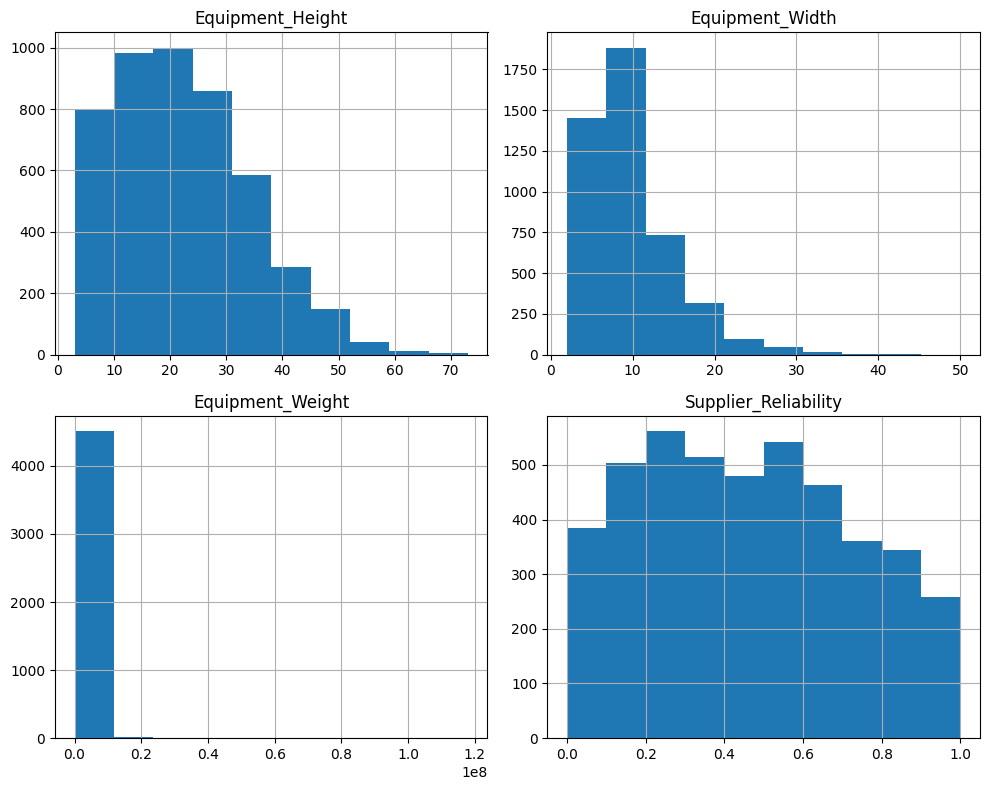


Value counts for categorical columns with missing values:

Equipment_Type:


Equipment_Type
Aluminium    655
Bronze       648
Brass        625
Marble       624
Clay         624
Wood         619
Stone        606
NaN          599
Name: count, dtype: int64


Transport_Method:


Transport_Method
Roadways     1604
Airways      1364
NaN          1071
Waterways     961
Name: count, dtype: int64


Rural_Hospital:


Rural_Hospital
No     3527
Yes     887
NaN     586
Name: count, dtype: int64

In [83]:
# Leaving aside the non-numerical columns, First dealing with null values of numerical Columns.
# Plot histograms for numerical columns to check for normal distribution
print("Histograms for numerical columns with missing values:")
train_ds[numeric_features_median].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

# Now dealing with Non-numerical Columns
# Display value counts for categorical columns with missing values
print("\nValue counts for categorical columns with missing values:")
for col in categorical_features_unknown:
    print(f"\n{col}:")
    display(train_ds[col].value_counts(dropna=False))

--- Imputation Comparison ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

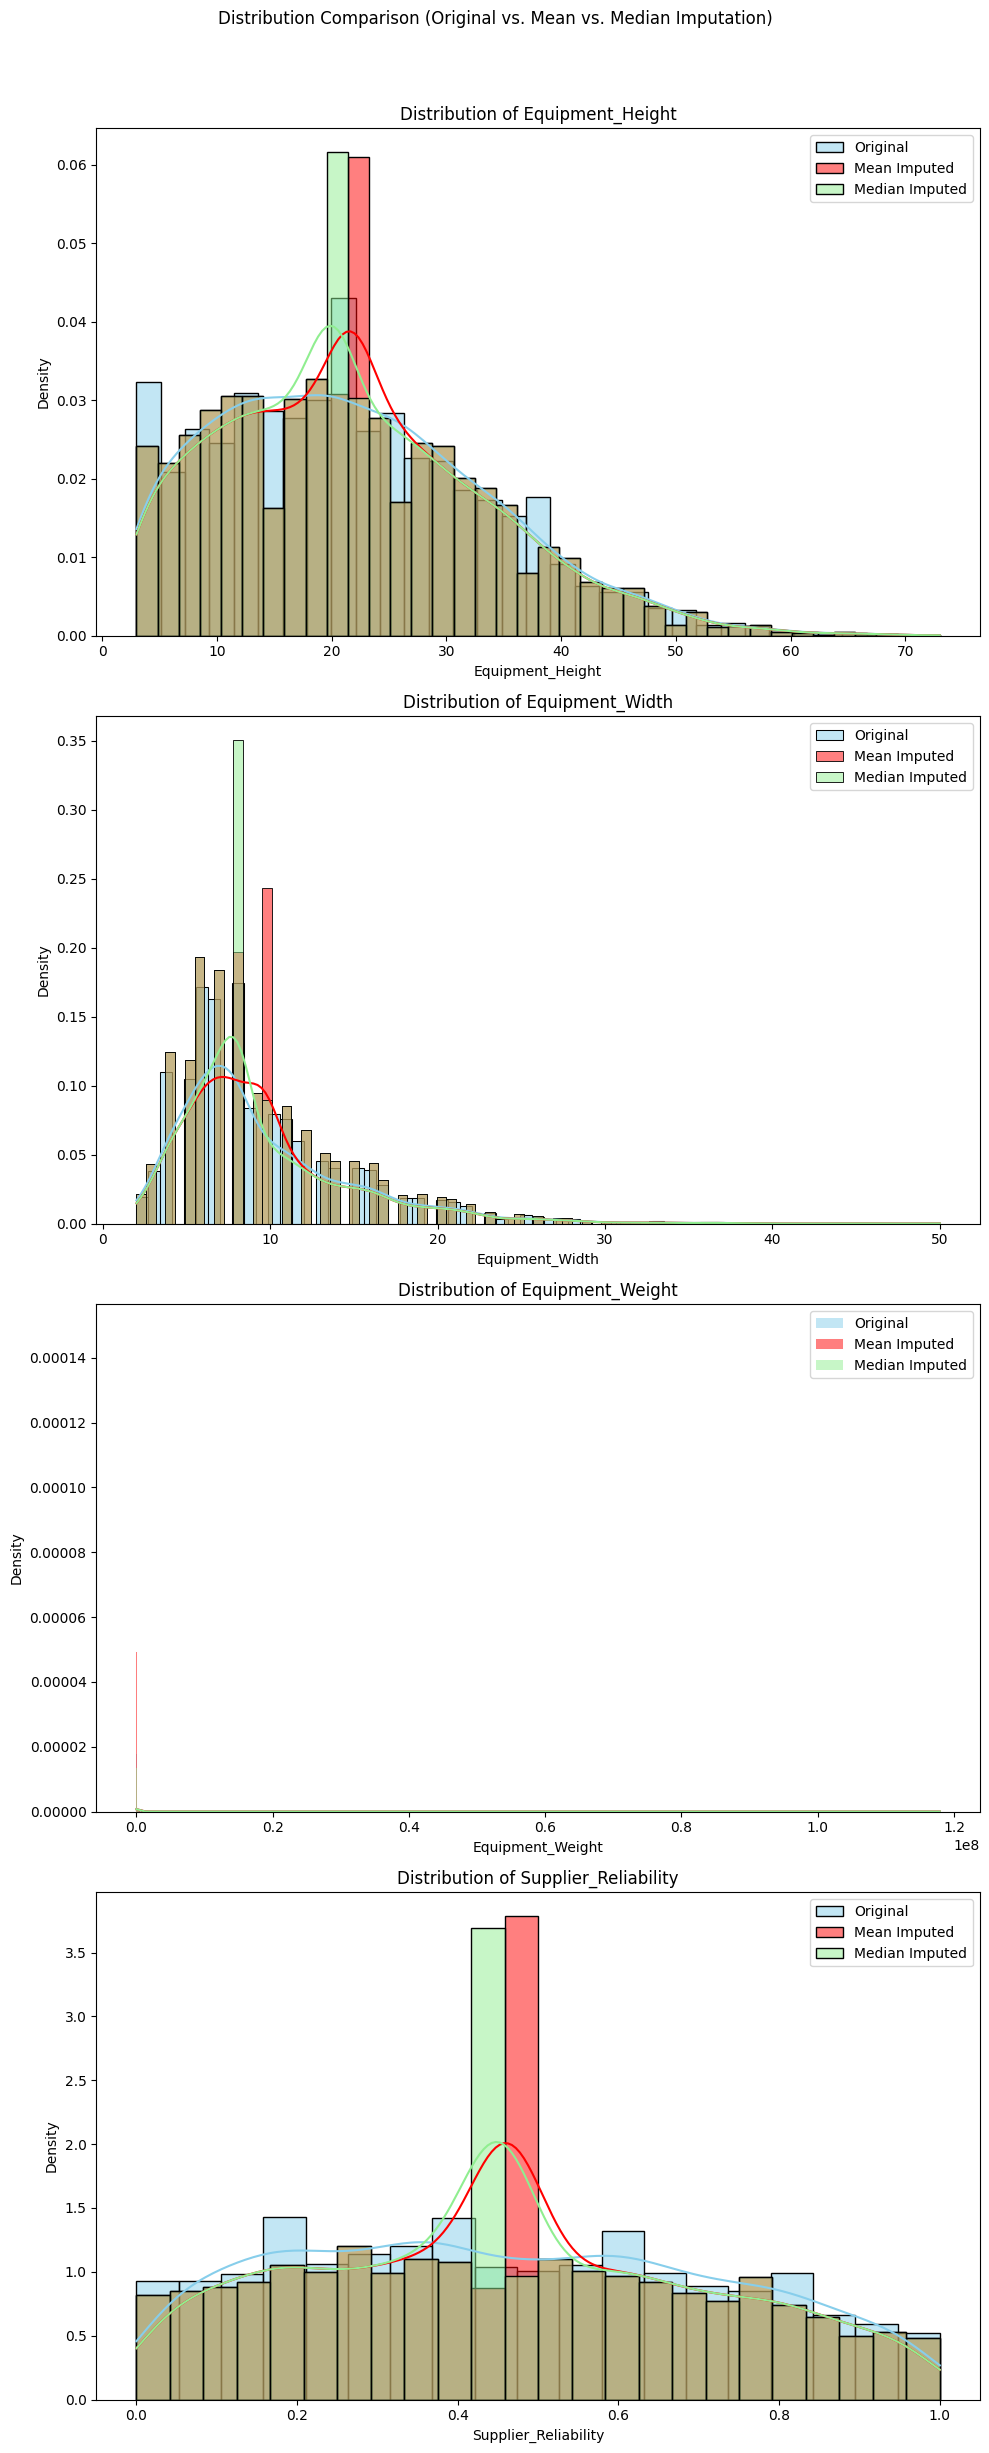


Variance Comparison:


,Original,Mean Imputed,Median Imputed
Equipment_Height,1.426695e+02,1.345928e+02,1.347582e+02
Equipment_Width,2.924151e+01,2.665019e+01,2.685310e+01
Equipment_Weight,7.888458e+12,7.162575e+12,7.176390e+12
Supplier_Reliability,7.073668e-02,6.243053e-02,6.244290e-02


In [84]:
# For numerical Columns Null Values, debate on whether to impute Mean/Median. 
# Solution: by observing the mean and median imputed distributions, which distribution is close to the orginal you take that for your column null value

# Create a copy for mean imputation
train_ds_mean_imputed = train_ds.copy()
for col in numeric_features_median:
    train_ds_mean_imputed[col] = train_ds_mean_imputed[col].fillna(train_ds_mean_imputed[col].mean())

# Create a copy for median imputation
train_ds_median_imputed = train_ds.copy()
for col in numeric_features_median:
    train_ds_median_imputed[col] = train_ds_median_imputed[col].fillna(train_ds_median_imputed[col].median())

# Display distributions and variances for mean imputed data
print("--- Imputation Comparison ---")

# Plot distributions
fig, axes = plt.subplots(nrows=len(numeric_features_median), ncols=1, figsize=(10, 6 * len(numeric_features_median)))
fig.suptitle("Distribution Comparison (Original vs. Mean vs. Median Imputation)", y=1.02)

for i, col in enumerate(numeric_features_median):
    sns.histplot(train_ds[col], ax=axes[i], color='skyblue', label='Original', kde=True, stat='density', common_norm=False)
    sns.histplot(train_ds_mean_imputed[col], ax=axes[i], color='red', label='Mean Imputed', kde=True, stat='density', common_norm=False)
    sns.histplot(train_ds_median_imputed[col], ax=axes[i], color='lightgreen', label='Median Imputed', kde=True, stat='density', common_norm=False)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].legend()

plt.tight_layout()
plt.show()


# Display variances
print("\nVariance Comparison:")
variance_comparison = pd.DataFrame({
    'Original': train_ds[numeric_features_median].var(),
    'Mean Imputed': train_ds_mean_imputed[numeric_features_median].var(),
    'Median Imputed': train_ds_median_imputed[numeric_features_median].var()
})
display(variance_comparison)

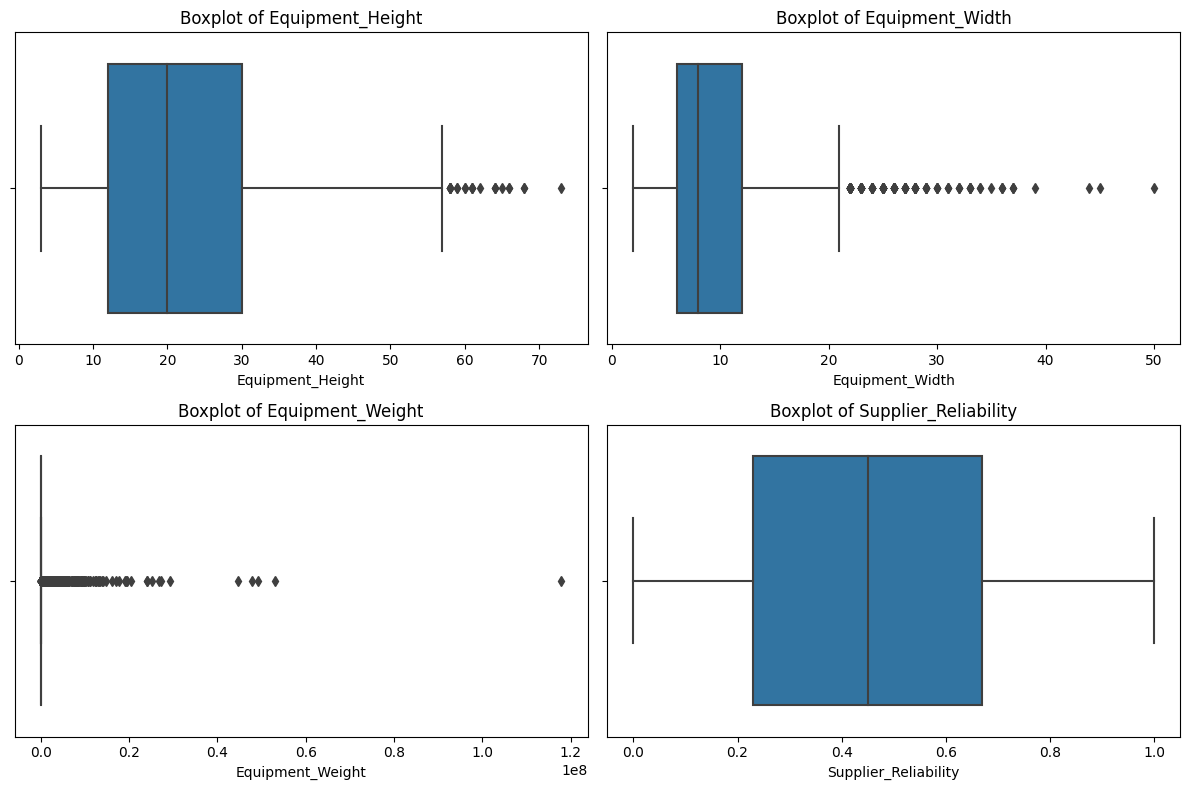

In [85]:
# Generating Box plots to observe outliers for the numerical columns with missing values
# Create boxplots
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_features_median):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=train_ds[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

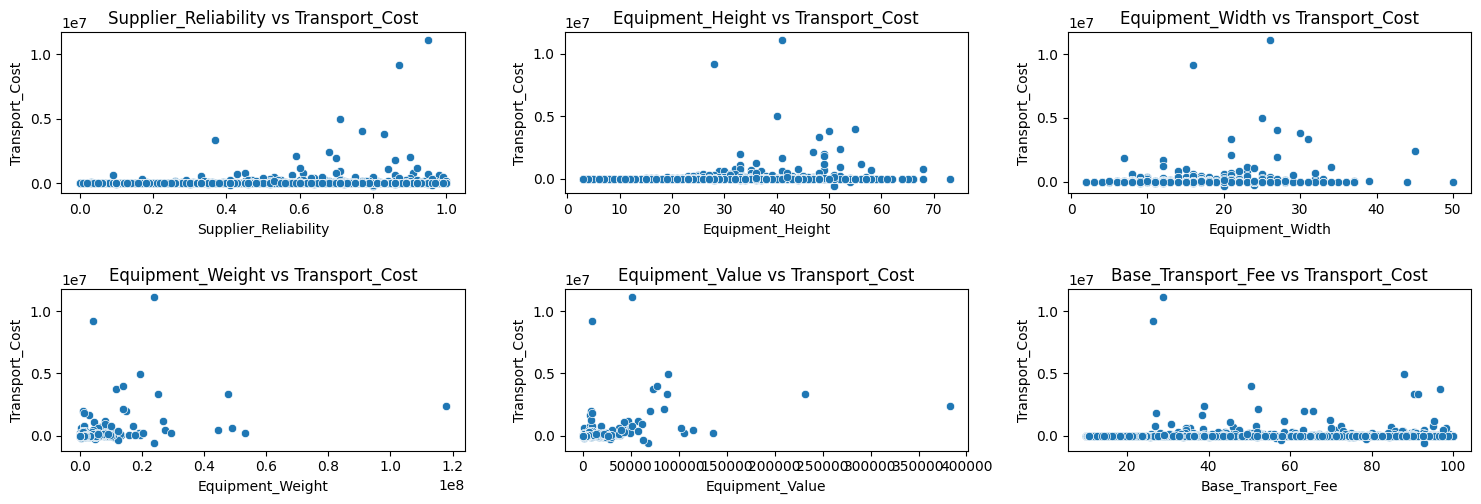

In [86]:
# Checking the distribution of each numerical column with Target column


numerical_cols = ['Supplier_Reliability', 'Equipment_Height', 'Equipment_Width', 'Equipment_Weight', 'Equipment_Value', 'Base_Transport_Fee', 'Delivery_Duration', 'Equipment_Volume', 'Value_to_Weight_Ratio', 'HighValue_Heavy']

# Filter numerical_cols to include only columns present in train_ds
existing_numerical_cols = [col for col in numerical_cols if col in train_ds.columns]

plt.figure(figsize=(15, 10))
for i, col in enumerate(existing_numerical_cols):
    plt.subplot(4, 3, i + 1)
    sns.scatterplot(data=train_ds, x=col, y='Transport_Cost')
    plt.title(f'{col} vs Transport_Cost')

plt.tight_layout()
plt.show()

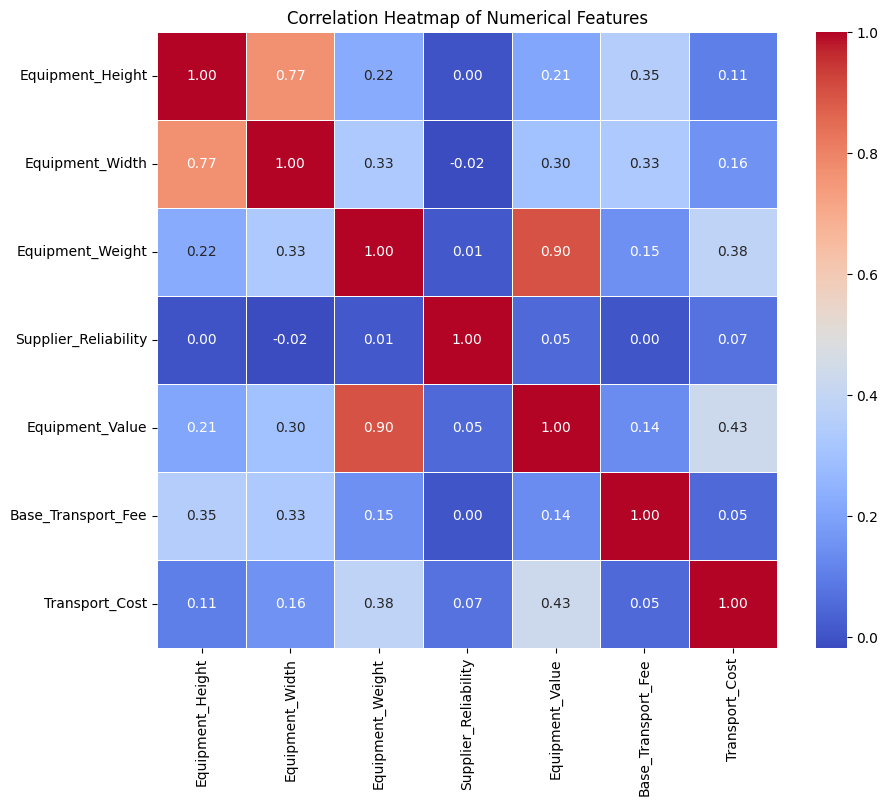

In [87]:
# Select only numerical features including target
numerical_cols = numeric_features_median + no_missing_features_numerical + [target]
numerical_data = train_ds[numerical_cols]

# Compute correlation matrix
corr_matrix = numerical_data.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix, 
    annot=True,           # show correlation values
    fmt=".2f",            # 2 decimal places
    cmap="coolwarm",      # color palette
    cbar=True,            # show color bar
    linewidths=0.5
)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


**Step 5:** Data preprocessing
> 1. Applied Robust Scailing
> 2. Imputed Median to missing valued numerical columns and date columns
> 3. Imputed mode to missing valued numerical columns

In [88]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

no_missing_numerical_transformer = Pipeline([
    ('scaler', RobustScaler())
])

no_missing_categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

date_transformer = Pipeline([
    ('date_feat', FunctionTransformer(compute_date_features, validate=False)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler(with_centering=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features_median),
    ('cat_unknown', categorical_transformer, categorical_features_unknown),
    ('date', date_transformer, date_features),
    ('num_no_missing', no_missing_numerical_transformer, no_missing_features_numerical),
    ('cat_no_missing', no_missing_categorical_transformer, no_missing_features_categorical)
], remainder='drop')

In [89]:
train_ds.sample(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Supplier_Reliability,Equipment_Height,Equipment_Width,Equipment_Weight,Equipment_Type,Equipment_Value,Base_Transport_Fee,CrossBorder_Shipping,Urgent_Shipping,Installation_Service,Transport_Method,Fragile_Equipment,Hospital_Info,Rural_Hospital,Order_Placed_Date,Delivery_Date,Transport_Cost
3182,0.89,9.0,5.0,2167.0,Marble,9.78,19.90,Yes,Yes,Yes,Airways,No,Working Class,No,04/09/19,04/07/19,2894.42
3277,0.33,24.0,16.0,28999.0,Bronze,24.88,70.83,No,No,No,Roadways,No,Working Class,No,05/31/17,05/31/17,685.15
2791,0.70,32.0,22.0,105447.0,Brass,108.71,83.23,No,No,No,Roadways,No,Working Class,No,03/10/16,03/13/16,2590.35
3501,0.35,24.0,NaN,184235.0,NaN,186.88,60.00,No,No,No,Roadways,No,Working Class,NaN,06/18/15,06/18/15,878.18
2509,0.91,NaN,NaN,NaN,NaN,4.19,24.10,No,Yes,No,Roadways,No,Working Class,Yes,12/21/17,12/19/17,290.30


In [90]:
# My complete data set after preprocessing to check how my data looks like after all the preprocessing
# Transform the training data (X)
X = train_ds.drop(columns=[target])
y = train_ds[target]

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

# Convert to a DataFrame with proper column names
# 1️⃣ Get feature names from the preprocessor
def get_feature_names(preprocessor):
    feature_names = []

    for name, trans, cols in preprocessor.transformers_:
        if name == 'date':
            # For date transformer, get output column names from compute_date_features
            sample_output = trans.named_steps['date_feat'].transform(X[cols].head(1))
            feature_names.extend([f"date_feat_{i}" for i in range(sample_output.shape[1])])
        elif hasattr(trans, 'get_feature_names_out'):
            feature_names.extend(trans.get_feature_names_out(cols))
        elif hasattr(trans, 'named_steps') and 'encoder' in trans.named_steps:
            enc = trans.named_steps['encoder']
            feature_names.extend(enc.get_feature_names_out(cols))
        else:
            feature_names.extend(cols)
    return feature_names

columns = get_feature_names(preprocessor)

# Create DataFrame
X_processed_df = pd.DataFrame(X_processed, columns=columns)
X_processed_df.head()


,Equipment_Height,Equipment_Width,Equipment_Weight,Supplier_Reliability,Equipment_Type_Brass,Equipment_Type_Bronze,Equipment_Type_Clay,Equipment_Type_Marble,Equipment_Type_Stone,Equipment_Type_Wood,...,date_feat_4,date_feat_5,date_feat_6,Equipment_Value,Base_Transport_Fee,Fragile_Equipment_Yes,Hospital_Info_Working Class,CrossBorder_Shipping_Yes,Urgent_Shipping_Yes,Installation_Service_Yes
0,0.0625,-0.4,0.000000,-0.027027,0.0,0.0,0.0,0.0,0.0,0.0,...,0.366025,0.0,0.0,-0.052759,-0.152520,0.0,1.0,0.0,0.0,0.0
1,0.5625,2.4,46.861342,0.351351,0.0,0.0,0.0,1.0,0.0,0.0,...,0.366025,0.0,0.0,118.544215,0.291682,0.0,1.0,0.0,1.0,1.0
2,1.1875,1.4,0.006500,1.405405,0.0,0.0,0.0,0.0,0.0,0.0,...,0.633975,0.0,0.0,0.394620,-0.118276,0.0,1.0,0.0,0.0,0.0
3,-0.7500,-0.6,-0.098240,0.675676,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.366025,1.0,1.0,-0.041388,-0.144019,0.0,1.0,0.0,0.0,0.0
4,0.4375,1.0,0.000000,0.567568,0.0,0.0,0.0,1.0,0.0,0.0,...,0.732051,0.0,1.0,33.243038,0.165634,0.0,1.0,1.0,0.0,0.0


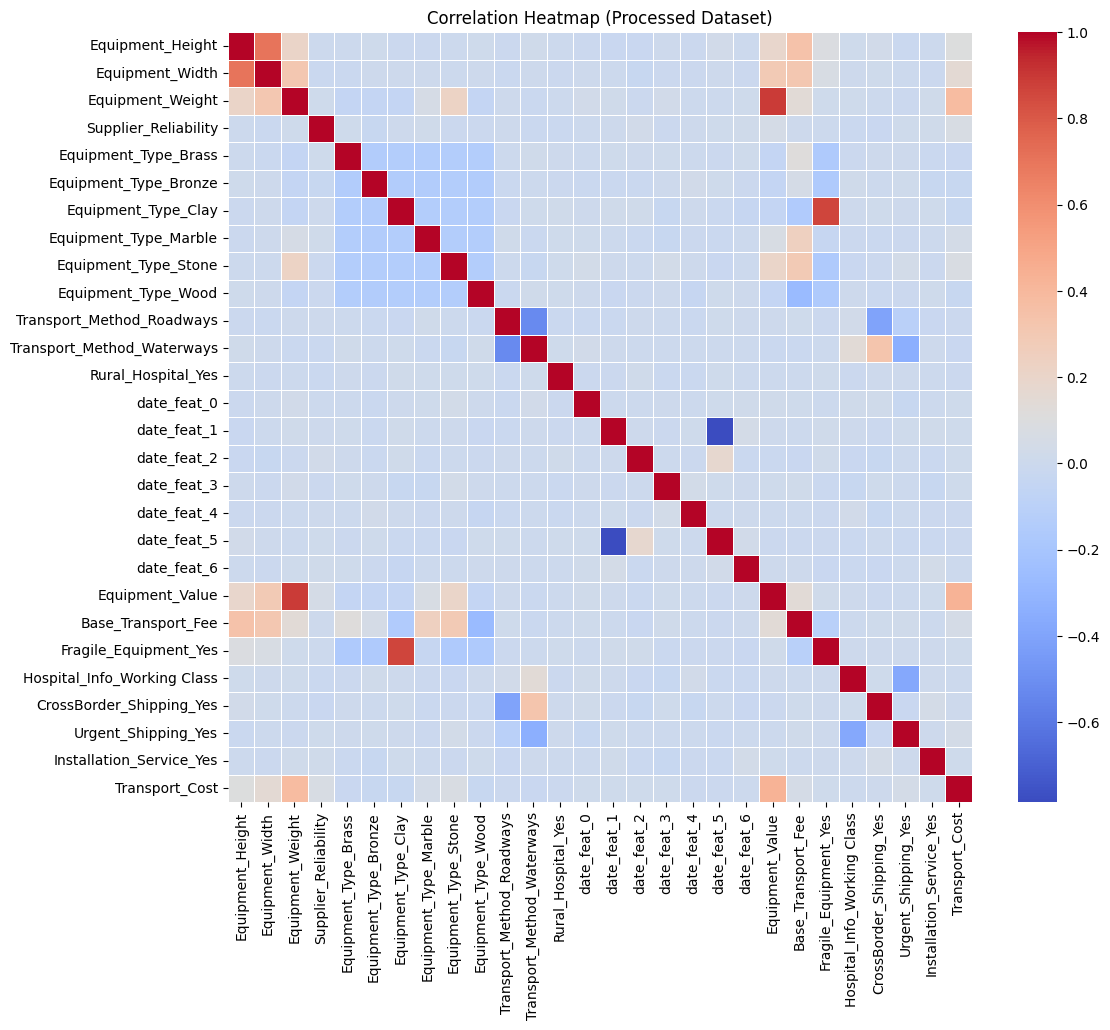

In [91]:
# Combine processed features and target into a single DataFrame
processed_data = X_processed_df.copy()
processed_data['Transport_Cost'] = y.values

# Compute correlation matrix
corr_matrix = processed_data.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    annot=False,           # show correlation values
    fmt=".2f",            # 2 decimal places
    cmap="coolwarm",      # color palette
    cbar=True,            # show color bar
    linewidths=0.5
)
plt.title("Correlation Heatmap (Processed Dataset)")
plt.show()


**Step 6:** Split Data
> Traditional split -> 80, 20

In [92]:
# Split processed data into 80% train and 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_processed_df,  # processed features
    y,               # target
    test_size=0.2,   # 20% validation, 80% training
    random_state=42  # for reproducibility
)

# Check shapes
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)


X_train: (4000, 27)
X_val: (1000, 27)
y_train: (4000,)
y_val: (1000,)


# Model Training Arc
1. Linear Regression
2. Polynomial Regression
3. Lasso Regression
4. Ridge Regression
5. Random Forest
6. ADA Boost
7. XG Boost
8. Elastic Net regression

In [93]:
# ================================================================
#                        LINEAR REGRESSION
# ================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# =======================
# 1️⃣ Load data
# =======================
train_ds = pd.read_csv('/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/train.csv')
test_ds = pd.read_csv('/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/test.csv')

target = "Transport_Cost"

# Split features and target
X = train_ds.drop(columns=[target])
y = train_ds[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# =======================
# 2️⃣ Define preprocessing pipelines
# =======================
numeric_features_median = ['Equipment_Height', 'Equipment_Width', 'Equipment_Weight', 'Supplier_Reliability']
categorical_features_unknown = ['Equipment_Type', 'Transport_Method', 'Rural_Hospital']
no_missing_features_numerical = ['Equipment_Value', 'Base_Transport_Fee']
no_missing_features_categorical = ['Fragile_Equipment', 'Hospital_Info', 'CrossBorder_Shipping', 'Urgent_Shipping', 'Installation_Service']
date_features = ['Order_Placed_Date', 'Delivery_Date']

def compute_date_features(df_dates):
    df = df_dates.copy()
    df = df.apply(pd.to_datetime, format="%m/%d/%y", errors="coerce")
    order = df.iloc[:, 0]
    delivery = df.iloc[:, 1]
    delivery_days = (delivery - order).dt.days
    order_dow = order.dt.dayofweek.fillna(-1).astype(float)
    order_month = order.dt.month.fillna(0).astype(float)
    delivery_dow = delivery.dt.dayofweek.fillna(-1).astype(float)
    delivery_month = delivery.dt.month.fillna(0).astype(float)
    order_is_weekend = order_dow.isin([5, 6]).astype(float)
    delivery_is_weekend = delivery_dow.isin([5, 6]).astype(float)

    def cyc(x, period):
        xr = x.replace(-1, 0)
        rad = 2 * np.pi * xr / period
        return np.sin(rad), np.cos(rad)

    order_dow_sin, order_dow_cos = cyc(order_dow, 7)
    order_month_sin, order_month_cos = cyc(order_month, 12)

    features = pd.DataFrame({
        "delivery_days": delivery_days,
        "order_dow_sin": order_dow_sin,
        "order_dow_cos": order_dow_cos,
        "order_month_sin": order_month_sin,
        "order_month_cos": order_month_cos,
        "order_is_weekend": order_is_weekend,
        "delivery_is_weekend": delivery_is_weekend,
    })
    features.index = df_dates.index
    return features

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

no_missing_numerical_transformer = Pipeline([
    ('scaler', RobustScaler())
])

no_missing_categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

date_transformer = Pipeline([
    ('date_feat', FunctionTransformer(compute_date_features, validate=False)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler(with_centering=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features_median),
    ('cat_unknown', categorical_transformer, categorical_features_unknown),
    ('date', date_transformer, date_features),
    ('num_no_missing', no_missing_numerical_transformer, no_missing_features_numerical),
    ('cat_no_missing', no_missing_categorical_transformer, no_missing_features_categorical)
], remainder='drop')

# =======================
# 3️⃣ Preprocess data
# =======================
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(test_ds)

# =======================
# 4️⃣ Train Linear Regression
# =======================
lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train)

# =======================
# 5️⃣ Validate
# =======================
y_val_pred = lr_model.predict(X_val_processed)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
print(f"Linear Regression | MAE (Validation) = {mae_val:.2f}")
print(f"Linear Regression | R² (Validation) = {r2_val:.3f}")

# =======================
# 6️⃣ Feature coefficients (optional)
# =======================
print("✅ Linear Regression trained successfully.")

# =======================
# 7️⃣ Predict on test set and save CSV
# =======================
y_test_pred = lr_model.predict(X_test_processed)
submission = pd.DataFrame({
    'Hospital_Id': test_ds['Hospital_Id'],
    'Transport_Cost': y_test_pred
})
submission.to_csv('linear_regression_predictions.csv', index=False)
print("✅ Predictions saved to 'linear_regression_predictions.csv'")


Linear Regression | MAE (Validation) = 25985.28
Linear Regression | R² (Validation) = -0.064
✅ Linear Regression trained successfully.
✅ Predictions saved to 'linear_regression_predictions.csv'


In [94]:
# ================================================================
#                        POLYNOMIAL REGRESSION
# ================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# =======================
# 1️⃣ Load data
# =======================
train_ds = pd.read_csv('/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/train.csv')
test_ds = pd.read_csv('/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/test.csv')

target = "Transport_Cost"

X = train_ds.drop(columns=[target])
y = train_ds[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# =======================
# 2️⃣ Preprocessor (same as Linear Regression)
# =======================
numeric_features_median = ['Equipment_Height', 'Equipment_Width', 'Equipment_Weight', 'Supplier_Reliability']
categorical_features_unknown = ['Equipment_Type', 'Transport_Method', 'Rural_Hospital']
no_missing_features_numerical = ['Equipment_Value', 'Base_Transport_Fee']
no_missing_features_categorical = ['Fragile_Equipment', 'Hospital_Info', 'CrossBorder_Shipping', 'Urgent_Shipping', 'Installation_Service']
date_features = ['Order_Placed_Date', 'Delivery_Date']

def compute_date_features(df_dates):
    df = df_dates.copy()
    df = df.apply(pd.to_datetime, format="%m/%d/%y", errors="coerce")
    order = df.iloc[:, 0]
    delivery = df.iloc[:, 1]
    delivery_days = (delivery - order).dt.days
    order_dow = order.dt.dayofweek.fillna(-1).astype(float)
    order_month = order.dt.month.fillna(0).astype(float)
    delivery_dow = delivery.dt.dayofweek.fillna(-1).astype(float)
    delivery_month = delivery.dt.month.fillna(0).astype(float)
    order_is_weekend = order_dow.isin([5, 6]).astype(float)
    delivery_is_weekend = delivery_dow.isin([5, 6]).astype(float)

    def cyc(x, period):
        xr = x.replace(-1, 0)
        rad = 2 * np.pi * xr / period
        return np.sin(rad), np.cos(rad)

    order_dow_sin, order_dow_cos = cyc(order_dow, 7)
    order_month_sin, order_month_cos = cyc(order_month, 12)

    features = pd.DataFrame({
        "delivery_days": delivery_days,
        "order_dow_sin": order_dow_sin,
        "order_dow_cos": order_dow_cos,
        "order_month_sin": order_month_sin,
        "order_month_cos": order_month_cos,
        "order_is_weekend": order_is_weekend,
        "delivery_is_weekend": delivery_is_weekend,
    })
    features.index = df_dates.index
    return features

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

no_missing_numerical_transformer = Pipeline([
    ('scaler', RobustScaler())
])

no_missing_categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

date_transformer = Pipeline([
    ('date_feat', FunctionTransformer(compute_date_features, validate=False)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler(with_centering=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features_median),
    ('cat_unknown', categorical_transformer, categorical_features_unknown),
    ('date', date_transformer, date_features),
    ('num_no_missing', no_missing_numerical_transformer, no_missing_features_numerical),
    ('cat_no_missing', no_missing_categorical_transformer, no_missing_features_categorical)
], remainder='drop')

# =======================
# 3️⃣ Polynomial Regression Pipeline
# =======================
poly_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', LinearRegression())
])

# =======================
# 4️⃣ Fit model
# =======================
poly_pipeline.fit(X_train, y_train)

# =======================
# 5️⃣ Evaluate on validation
# =======================
y_val_pred = poly_pipeline.predict(X_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
print(f"Polynomial Regression | MAE (Validation) = {mae_val:.2f}")
print(f"Polynomial Regression | R² (Validation) = {r2_val:.3f}")

# =======================
# 6️⃣ Predict on test set
# =======================
X_test = test_ds.copy()
y_test_pred = poly_pipeline.predict(X_test)

# =======================
# 7️⃣ Save predictions
# =======================
submission = pd.DataFrame({
    'Hospital_Id': test_ds['Hospital_Id'],
    'Transport_Cost': y_test_pred
})
submission.to_csv('polynomial_regression_predictions.csv', index=False)
print("✅ Polynomial Regression predictions saved successfully")


Polynomial Regression | MAE (Validation) = 58293.44
Polynomial Regression | R² (Validation) = -7.409
✅ Polynomial Regression predictions saved successfully


In [95]:
# ================================================================
#                        LASSO REGRESSION - fixed params
# ================================================================
from sklearn.linear_model import Lasso

# =======================
# Lasso Pipeline
# =======================
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.01, max_iter=10000, random_state=42))
])

# Fit model
lasso_pipeline.fit(X_train, y_train)

# Evaluate on validation
y_val_pred = lasso_pipeline.predict(X_val)
print(f"Lasso Regression | MAE (Validation) = {mean_absolute_error(y_val, y_val_pred):.2f}")
print(f"Lasso Regression | R² (Validation) = {r2_score(y_val, y_val_pred):.3f}")

# Predict on test set
y_test_pred = lasso_pipeline.predict(test_ds)

# Save submission
submission = pd.DataFrame({
    'Hospital_Id': test_ds['Hospital_Id'],
    'Transport_Cost': y_test_pred
})
submission.to_csv('lasso_regression_predictions.csv', index=False)
print("✅ Lasso Regression predictions saved successfully")


Lasso Regression | MAE (Validation) = 25985.22
Lasso Regression | R² (Validation) = -0.064
✅ Lasso Regression predictions saved successfully


In [96]:
# ================================================================
#                  LASSO REGRESSION using GRIDSEARCHCV
# ================================================================
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(max_iter=10000, random_state=42))
])

param_grid_lasso = {
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

grid_lasso = GridSearchCV(
    lasso_pipeline,
    param_grid=param_grid_lasso,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_lasso.fit(X_train, y_train)

print("✅ Best Lasso alpha:", grid_lasso.best_params_['regressor__alpha'])
print("✅ Best CV R²:", grid_lasso.best_score_)

y_val_pred = grid_lasso.predict(X_val)
print("Validation R²:", r2_score(y_val, y_val_pred))
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))

y_test_pred = grid_lasso.predict(test_ds)
submission = pd.DataFrame({'Hospital_Id': test_ds['Hospital_Id'], 'Transport_Cost': y_test_pred})
submission.to_csv('lasso_gridsearch.csv', index=False)
print("✅ Lasso predictions saved")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Best Lasso alpha: 10
✅ Best CV R²: 0.0180123494254139
Validation R²: -0.06190974992126974
Validation MAE: 25922.39128816671
✅ Lasso predictions saved


In [97]:
# ================================================================
#                        RIDGE REGRESSION
# ================================================================
from sklearn.linear_model import Ridge

# =======================
# Ridge Pipeline
# =======================
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0, max_iter=10000, random_state=42))
])

# Fit model
ridge_pipeline.fit(X_train, y_train)

# Evaluate on validation
y_val_pred = ridge_pipeline.predict(X_val)
print(f"Ridge Regression | MAE (Validation) = {mean_absolute_error(y_val, y_val_pred):.2f}")
print(f"Ridge Regression | R² (Validation) = {r2_score(y_val, y_val_pred):.3f}")

# Predict on test set
y_test_pred = ridge_pipeline.predict(test_ds)

# Save submission
submission = pd.DataFrame({
    'Hospital_Id': test_ds['Hospital_Id'],
    'Transport_Cost': y_test_pred
})
submission.to_csv('ridge_regression_predictions.csv', index=False)
print("✅ Ridge Regression predictions saved successfully")


Ridge Regression | MAE (Validation) = 25965.91
Ridge Regression | R² (Validation) = -0.063
✅ Ridge Regression predictions saved successfully


In [98]:
# ================================================================
#               RIDGE REGRESSION using GRIDSEARCHCV
# ================================================================
from sklearn.linear_model import Ridge

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(max_iter=10000, random_state=42))
])

param_grid_ridge = {
    'regressor__alpha': [0.01, 0.1, 1, 10, 50, 100]
}

grid_ridge = GridSearchCV(
    ridge_pipeline,
    param_grid=param_grid_ridge,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_ridge.fit(X_train, y_train)

print("✅ Best Ridge alpha:", grid_ridge.best_params_['regressor__alpha'])
print("✅ Best CV R²:", grid_ridge.best_score_)

y_val_pred = grid_ridge.predict(X_val)
print("Validation R²:", r2_score(y_val, y_val_pred))
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))

y_test_pred = grid_ridge.predict(test_ds)
submission = pd.DataFrame({'Hospital_Id': test_ds['Hospital_Id'], 'Transport_Cost': y_test_pred})
submission.to_csv('ridge_gridsearch.csv', index=False)
print("✅ Ridge predictions saved")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Best Ridge alpha: 100
✅ Best CV R²: 0.0326114925853054
Validation R²: -0.019495446459303345
Validation MAE: 24467.356556071372
✅ Ridge predictions saved


In [99]:
# ================================================================
#              RANDOM FOREST REGRESSION - fixed params
# ================================================================
from sklearn.ensemble import RandomForestRegressor

# =======================
# Random Forest Pipeline
# =======================
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200, max_depth=10, random_state=42, n_jobs=-1))
])

# Fit model
rf_pipeline.fit(X_train, y_train)

# Evaluate on validation
y_val_pred = rf_pipeline.predict(X_val)
print(f"Random Forest | MAE (Validation) = {mean_absolute_error(y_val, y_val_pred):.2f}")
print(f"Random Forest | R² (Validation) = {r2_score(y_val, y_val_pred):.3f}")

# Predict on test set
y_test_pred = rf_pipeline.predict(test_ds)

# Save submission
submission = pd.DataFrame({
    'Hospital_Id': test_ds['Hospital_Id'],
    'Transport_Cost': y_test_pred
})
submission.to_csv('random_forest_predictions.csv', index=False)
print("✅ Random Forest predictions saved successfully")


Random Forest | MAE (Validation) = 9587.74
Random Forest | R² (Validation) = -2.309
✅ Random Forest predictions saved successfully


In [100]:
# ================================================================
#            RANDOM FOREST REGRESSION using GRIDSEARCHCV
# ================================================================
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [5, 10, 15, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_train, y_train)

print("✅ Best RF Params:", grid_rf.best_params_)
print("✅ Best CV R²:", grid_rf.best_score_)

y_val_pred = grid_rf.predict(X_val)
print("Validation R²:", r2_score(y_val, y_val_pred))
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))

y_test_pred = grid_rf.predict(test_ds)
submission = pd.DataFrame({'Hospital_Id': test_ds['Hospital_Id'], 'Transport_Cost': y_test_pred})
submission.to_csv('random_forest_gridsearch.csv', index=False)
print("✅ Random Forest predictions saved")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END regressor__learning_rate=0.01, regressor__loss=linear, regressor__n_estimators=50; total time=   0.7s
[CV] END regressor__learning_rate=0.01, regressor__loss=linear, regressor__n_estimators=100; total time=   1.2s
[CV] END regressor__learning_rate=0.01, regressor__loss=square, regressor__n_estimators=50; total time=   0.7s
[CV] END regressor__learning_rate=0.01, regressor__loss=square, regressor__n_estimators=50; total time=   0.7s
[CV] END regressor__learning_rate=0.01, regressor__loss=square, regressor__n_estimators=100; total time=   1.2s
[CV] END regressor__learning_rate=0.01, regressor__loss=square, regressor__n_estimators=200; total time=   2.3s
[CV] END regressor__learning_rate=0.01, regressor__loss=exponential, regressor__n_estimators=100; total time=   1.4s
[CV] END regressor__learning_rate=0.01, regressor__loss=exponential, regressor__n_estimators=200; total time=   2.3s
[CV] END regressor__learning_rate=

In [101]:
# ================================================================
#                ADA BOOST REGRESSION - fixed params
# ================================================================
from sklearn.ensemble import AdaBoostRegressor

# -------------------------------
# Pipeline
# -------------------------------
ada_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', AdaBoostRegressor(random_state=42))
])

# -------------------------------
# Fit on training data
# -------------------------------
ada_pipeline.fit(X_train, y_train)

# -------------------------------
# Predict on validation
# -------------------------------
y_val_pred = ada_pipeline.predict(X_val)

print("--- AdaBoost Validation ---")
print("MAE:", mean_absolute_error(y_val, y_val_pred))
print("R²:", r2_score(y_val, y_val_pred))

# -------------------------------
# Predict on test set
# -------------------------------
y_test_pred = ada_pipeline.predict(test_ds)

submission = pd.DataFrame({
    'Hospital_Id': test_ds['Hospital_Id'],
    'Transport_Cost': y_test_pred
})
submission.to_csv('adaboost_predictions.csv', index=False)
print("✅ AdaBoost predictions saved")


--- AdaBoost Validation ---
MAE: 13651.954085018793
R²: -0.7058552330152226
✅ AdaBoost predictions saved


In [102]:
# ================================================================
#             ADA BOOST REGRESSION using GRIDSEARCHCV
# ================================================================
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor

# -------------------------------
# Pipeline
# -------------------------------
ada_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', AdaBoostRegressor(random_state=42))
])

# -------------------------------
# Hyperparameter Grid
# -------------------------------
param_grid_ada = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'regressor__loss': ['linear', 'square', 'exponential']
}

grid_ada = GridSearchCV(
    ada_pipeline,
    param_grid=param_grid_ada,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

# -------------------------------
# Fit GridSearch
# -------------------------------
grid_ada.fit(X_train, y_train)

print("✅ Best AdaBoost Params:", grid_ada.best_params_)
print("✅ Best CV R²:", grid_ada.best_score_)

# -------------------------------
# Evaluate on validation
# -------------------------------
y_val_pred = grid_ada.predict(X_val)
print("--- AdaBoost Validation ---")
print("MAE:", mean_absolute_error(y_val, y_val_pred))
print("R²:", r2_score(y_val, y_val_pred))

# -------------------------------
# Predict on test set
# -------------------------------
y_test_pred = grid_ada.predict(test_ds)
submission = pd.DataFrame({
    'Hospital_Id': test_ds['Hospital_Id'],
    'Transport_Cost': y_test_pred
})
submission.to_csv('adaboost_gridsearch_predictions.csv', index=False)
print("✅ AdaBoost GridSearch predictions saved")


Fitting 3 folds for each of 45 candidates, totalling 135 fits

[CV] END regressor__max_depth=10, regressor__min_samples_leaf=2, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   2.4s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=2, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   2.5s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=2, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   4.1s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=2, regressor__min_samples_split=2, regressor__n_estimators=300; total time=   5.9s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=300; total time=   6.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=2, regressor__min_samples_split=10, regressor__n_estimators=100; total time=   2.4s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=2, r

In [103]:
# ================================================================
#                XG BOOST REGRESSION - fixed params
# ================================================================
from xgboost import XGBRegressor

# =======================
# XGBoost Pipeline
# =======================
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    ))
])

# Fit model
xgb_pipeline.fit(X_train, y_train)

# Evaluate on validation
y_val_pred = xgb_pipeline.predict(X_val)
print(f"XGBoost | MAE (Validation) = {mean_absolute_error(y_val, y_val_pred):.2f}")
print(f"XGBoost | R² (Validation) = {r2_score(y_val, y_val_pred):.3f}")

# Predict on test set
y_test_pred = xgb_pipeline.predict(test_ds)

# Save submission
submission = pd.DataFrame({
    'Hospital_Id': test_ds['Hospital_Id'],
    'Transport_Cost': y_test_pred
})
submission.to_csv('xgboost_predictions.csv', index=False)
print("✅ XGBoost predictions saved successfully")


XGBoost | MAE (Validation) = 12976.56
XGBoost | R² (Validation) = -5.710
✅ XGBoost predictions saved successfully


In [104]:
# ================================================================
#              XG BOOST REGRESSION using GRIDSEARCHCV
# ================================================================
from xgboost import XGBRegressor

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

param_grid_xgb = {
    'regressor__n_estimators': [200, 400],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.7, 0.8, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 1.0]
}

grid_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid_xgb,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_xgb.fit(X_train, y_train)

print("✅ Best XGB Params:", grid_xgb.best_params_)
print("✅ Best CV R²:", grid_xgb.best_score_)

y_val_pred = grid_xgb.predict(X_val)
print("Validation R²:", r2_score(y_val, y_val_pred))
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))

y_test_pred = grid_xgb.predict(test_ds)
submission = pd.DataFrame({'Hospital_Id': test_ds['Hospital_Id'], 'Transport_Cost': y_test_pred})
submission.to_csv('xgboost_gridsearch.csv', index=False)
print("✅ XGBoost predictions saved")


Fitting 3 folds for each of 162 candidates, totalling 486 fits

[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   6.2s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   3.4s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   3.2s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=200; total time=   6.0s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=300; total time=   8.6s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=10, regressor__n_estimators=200; total time=   6.0s
[CV] END regressor__learning_rate=0.01, regressor__lo

In [105]:
# ================================================================
#                    ELASTIC NET REGRESSION
# ================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# ===============================
# 1️⃣ DATA LOADING
# ===============================
train_ds = pd.read_csv('/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/train.csv')
test_ds = pd.read_csv('/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/test.csv')

hospital_id_test = test_ds["Hospital_Id"]
drop_cols = ["Hospital_Id", "Supplier_Name", "Hospital_Location"]
train_ds = train_ds.drop(columns=drop_cols)
test_ds = test_ds.drop(columns=drop_cols)

target = "Transport_Cost"
train_ds = train_ds.dropna(subset=[target])

# ===============================
# 🚫 REMOVE OUTLIERS ABOVE 80th PERCENTILE
# ===============================
q80 = train_ds[target].quantile(0.044)
train_ds = train_ds[train_ds[target] >= q80]
print(f"Removed outliers above 80th percentile (>{q80:.2f}). Remaining samples: {len(train_ds)}")

# ===============================
# 2️⃣ FEATURE GROUPS
# ===============================
numeric_features_median = ['Equipment_Height', 'Equipment_Weight', 'Supplier_Reliability']
categorical_features_unknown = ['Equipment_Type', 'Transport_Method', 'Rural_Hospital']
no_missing_features_numerical = ['Equipment_Value', 'Base_Transport_Fee']
no_missing_features_categorical = ['Fragile_Equipment', 'Hospital_Info', 'CrossBorder_Shipping', 'Urgent_Shipping', 'Installation_Service']
date_features = ['Order_Placed_Date', 'Delivery_Date']

# ===============================
# 3️⃣ DATE FUNCTION
# ===============================
def compute_date_features(df_dates):
    df = df_dates.copy()
    df = df.apply(pd.to_datetime, format="%m/%d/%y", errors="coerce")
    order = df.iloc[:, 0]
    delivery = df.iloc[:, 1]
    delivery_days = (delivery - order).dt.days
    order_dow = order.dt.dayofweek.fillna(-1).astype(float)
    order_month = order.dt.month.fillna(0).astype(float)
    delivery_dow = delivery.dt.dayofweek.fillna(-1).astype(float)
    delivery_month = delivery.dt.month.fillna(0).astype(float)
    order_is_weekend = order_dow.isin([5, 6]).astype(float)
    delivery_is_weekend = delivery_dow.isin([5, 6]).astype(float)

    def cyc(x, period):
        xr = x.replace(-1, 0)
        rad = 2 * np.pi * xr / period
        return np.sin(rad), np.cos(rad)

    order_dow_sin, order_dow_cos = cyc(order_dow, 7)
    order_month_sin, order_month_cos = cyc(order_month, 12)

    features = pd.DataFrame({
        "delivery_days": delivery_days,
        "order_dow_sin": order_dow_sin,
        "order_dow_cos": order_dow_cos,
        "order_month_sin": order_month_sin,
        "order_month_cos": order_month_cos,
    })
    features.index = df_dates.index
    return features

# ===============================
# 4️⃣ PREPROCESSORS
# ===============================
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

no_missing_numerical_transformer = Pipeline([
    ('scaler', RobustScaler())
])

no_missing_categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

date_transformer = Pipeline([
    ('date_feat', FunctionTransformer(compute_date_features, validate=False)),
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', RobustScaler(with_centering=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features_median),
    ('cat_unknown', categorical_transformer, categorical_features_unknown),
    ('date', date_transformer, date_features),
    ('num_no_missing', no_missing_numerical_transformer, no_missing_features_numerical),
    ('cat_no_missing', no_missing_categorical_transformer, no_missing_features_categorical)
], remainder='drop')

# ===============================
# 5️⃣ TRAIN-VALIDATION SPLIT
# ===============================
X = train_ds.drop(columns=[target])
y = train_ds[target].replace([np.inf, -np.inf], np.nan).fillna(0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ===============================
# 6️⃣ ELASTIC NET PIPELINE
# ===============================
elastic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', TransformedTargetRegressor(
        regressor=ElasticNet(max_iter=20000, random_state=42),
        transformer=PowerTransformer(method='yeo-johnson')
    ))
])

# ===============================
# 7️⃣ HYPERPARAMETER GRID
# ===============================
param_grid = {
    'regressor__regressor__alpha': [0.001, 0.01, 0.05, 0.1, 0.3, 0.5],
    'regressor__regressor__l1_ratio': [0.2, 0.5, 0.8, 1.0]
}

grid_search = GridSearchCV(
    elastic_pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# ===============================
# 8️⃣ TRAIN GRID SEARCH
# ===============================
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best ElasticNet params: {grid_search.best_params_}")

# ===============================
# 9️⃣ EVALUATE ON VALIDATION
# ===============================
y_pred = best_model.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"ElasticNetCV (GridSearch) | R² = {r2:.4f} | RMSE = {rmse:.2f}")

# ===============================
# 🔟 TRAIN ON FULL DATA & PREDICT TEST
# ===============================
best_model.fit(X, y)
y_pred_test = best_model.predict(test_ds)
submission = pd.DataFrame({
    "Hospital_Id": hospital_id_test,
    "Transport_Cost": y_pred_test
})
submission.to_csv("submission_elasticnet_grid.csv", index=False)
print("✅ submission_elasticnet_grid.csv created successfully")


Removed outliers above 80th percentile (>-538.65). Remaining samples: 4780
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best ElasticNet params: {'regressor__regressor__alpha': 0.001, 'regressor__regressor__l1_ratio': 0.2}
ElasticNetCV (GridSearch) | R² = 0.0144 | RMSE = 297813.64
✅ submission_elasticnet_grid.csv created successfully

[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=400, regressor__subsample=0.7; total time=   0.7s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=400, regressor__subsample=0.8; total time=   0.7s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=200, regressor__subsample=0.7; total time=   0.5s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=200, regressor__s